## Problem Identification
Regarding letter recognition, the challenge is to precisely identify and categorize individual letters in a variety of datasets. This includes the capacity to recognize and distinguish between various typefaces, alphabets, and handwriting styles regardless of changes in the input data's size, orientation, or quality. The difficulty is in creating a dependable and effective system that can automatically decipher and classify these letters, converting unprocessed visual data into representations that are comprehensible to machines.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import cv2
import os



##  Data Identification

In [2]:
df = pd.read_csv('dataset.csv')

In [3]:
df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Features/Columns

###### The dataset has 121465 entries and 785 columns. The first column is the column that indicates the letter i.e. 0 ->A, 1->B and so on. The other 784 columns represent the individual values of 28*28 matrix. Each value in the 28x28 matrix  denotes the intensity or grayscale value of a pixel in a grid that forms an image of the respective letter. The values in these columns  range from  0 to 255 in the case of grayscale values, representing the darkness or color intensity of each pixel in the image of the letter.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121465 entries, 0 to 121464
Columns: 785 entries, 0 to 0.648
dtypes: int64(785)
memory usage: 727.5 MB


In [4]:
df['0.640'].value_counts()

0      121463
178         1
226         1
Name: 0.640, dtype: int64

##  Data Acquistion and Filtering
 #### The next step is to visualize the image represented by the above 28*28 matrix values.
 ####  The codes below involves acquiring a subset of the dataset, transforming the pixel values into a binary format, reshaping the data, and visualizing the changes. These actions collectively represent a part of the data acquisition process by sampling data and a part of the filtering process by converting pixel values to binary form, preparing the data for subsequent analysis or model training in a big data context for letter recognition.

In [5]:
def get_binary_img(df):
    #Step 1: Make the pic black and white such that any pixel value more than 256/2 is black and less is white
    threshold = 128
    # Convert pixel values to black (0) or white (255) based on the threshold
    binary_img_array = np.where(df > threshold, 255, 0)

    return binary_img_array

def get_2d_array(data):
      # Check if the input is a DataFrame or a NumPy array
    if isinstance(data, (pd.DataFrame, pd.Series)):
        # If it's a DataFrame, convert it to a NumPy array
        image_array = data.values
    elif isinstance(data, np.ndarray):
        # If it's already a NumPy array, use it directly
        image_array = data
    else:
        raise ValueError("Input must be a DataFrame or a NumPy array")

    # Step 2: Convert the 1D array to a 2D array representing the 28x28 image
    image_array = image_array.reshape(28, 28)
    return image_array

# df_elements = df.sample(n=7)

# df.iloc[:, 1:]

In [6]:
df.head(1)

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


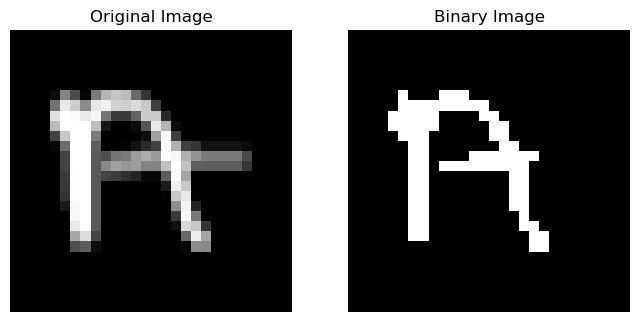

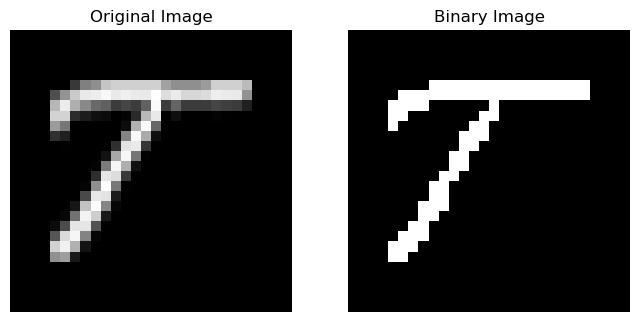

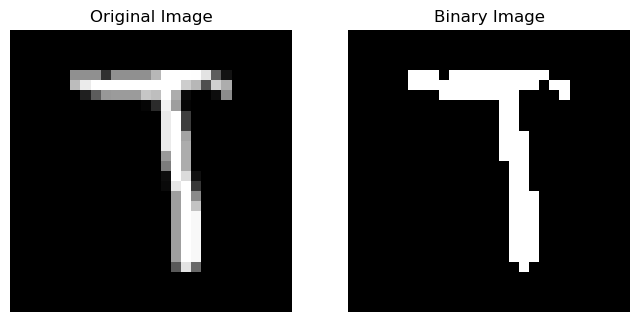

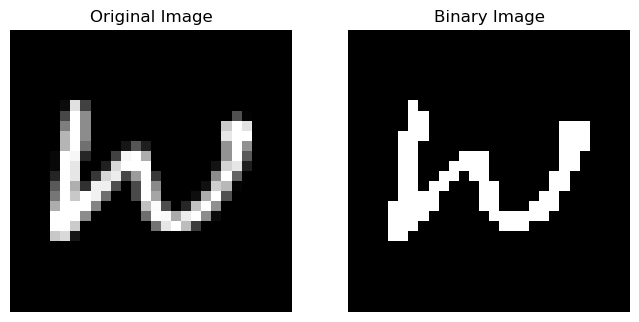

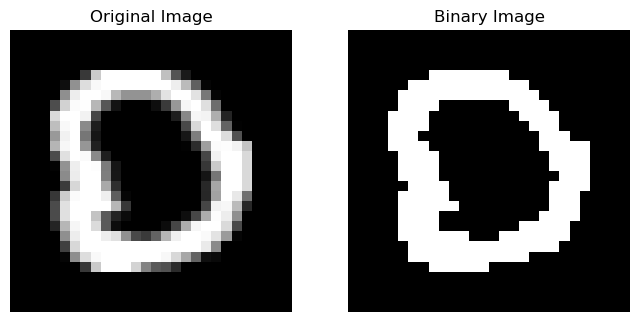

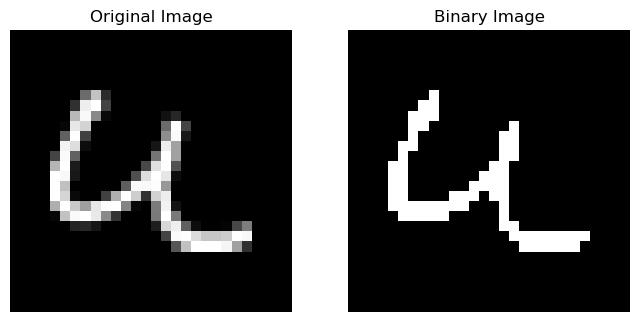

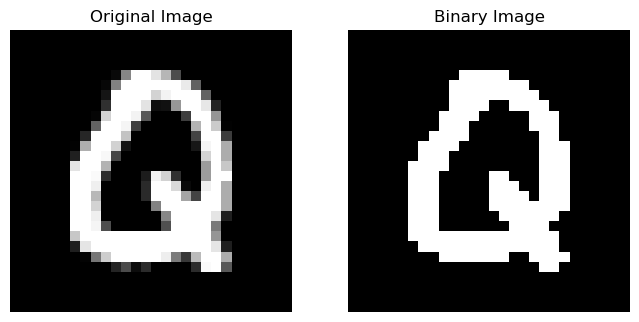

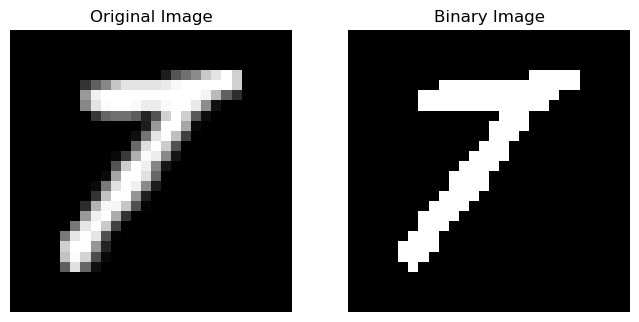

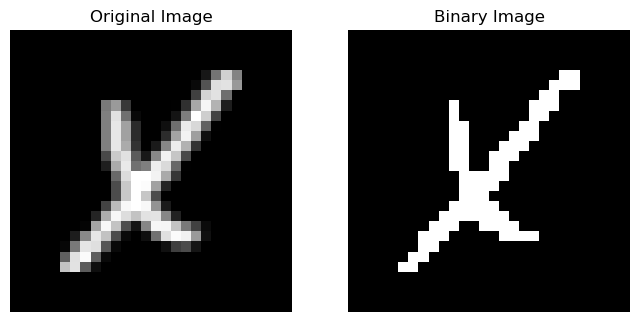

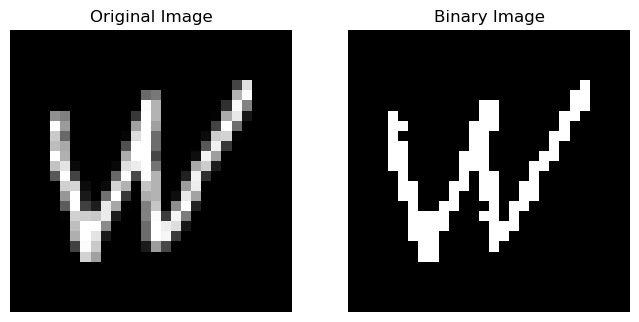

In [7]:
###Lets try visualizing few of these elements
df_elements = df.sample(n=10)
# Function to plot original and binary images
def plot_images(original, binary):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original Image')

    axes[1].imshow(binary, cmap='gray')
    axes[1].set_title('Binary Image')

    for ax in axes:
        ax.axis('off')

    plt.show()

for i in range(len(df_elements)):
    
    pixel_values = df_elements.iloc[i,1:]
    original_image = get_2d_array(pixel_values)
    binary_pixels = get_binary_img(pixel_values)
    binary_image = get_2d_array(binary_pixels)
    plot_images(original_image, binary_image)




In [8]:
# modify the pixel values to binary
for col in df.columns[1:]:
    # Convert the column to binary
    binary_column = get_binary_img(df[col])

    # Replace the existing values in the DataFrame with 0 and 255
    df[col] = binary_column

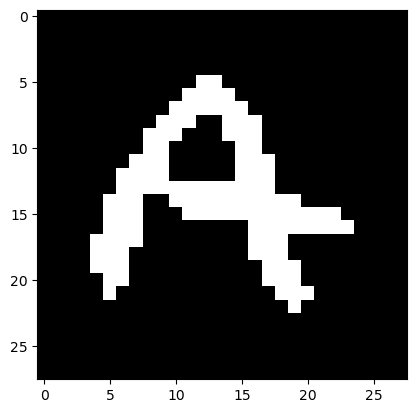

In [9]:
test_pixel_values = df.iloc[5,1:]
img = get_2d_array(test_pixel_values)
plt.imshow(img,cmap='gray')

In [10]:
df_2d = pd.DataFrame()

pixel_df = df.drop(columns=['0'])
df_2d['pixels'] = pixel_df.apply(lambda x: get_2d_array(x), axis=1)


In [11]:
df_2d.head()

,pixels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [12]:
val = df_2d['pixels'].iloc[5]

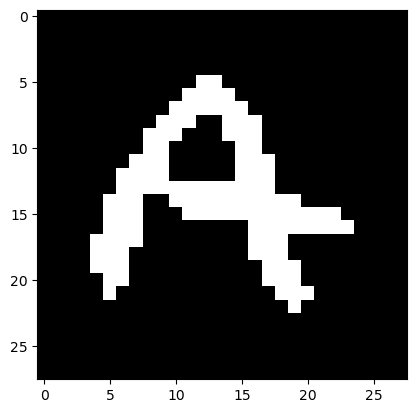

In [13]:
plt.imshow(val,cmap='gray')

In [14]:
#find the white pixels in the array and return the coordinate
def get_on_coords(pixels):
    on_pixel_coords = np.argwhere(pixels ==255)
    if not on_pixel_coords.size:
        return None  # No "on" pixels

    return on_pixel_coords

get_on_coords(val)

array([[ 5, 12],
       [ 5, 13],
       [ 6, 11],
       [ 6, 12],
       [ 6, 13],
       [ 6, 14],
       [ 7, 10],
       [ 7, 11],
       [ 7, 12],
       [ 7, 13],
       [ 7, 14],
       [ 7, 15],
       [ 8,  9],
       [ 8, 10],
       [ 8, 11],
       [ 8, 14],
       [ 8, 15],
       [ 8, 16],
       [ 9,  8],
       [ 9,  9],
       [ 9, 10],
       [ 9, 14],
       [ 9, 15],
       [ 9, 16],
       [10,  8],
       [10,  9],
       [10, 15],
       [10, 16],
       [11,  7],
       [11,  8],
       [11,  9],
       [11, 15],
       [11, 16],
       [11, 17],
       [12,  6],
       [12,  7],
       [12,  8],
       [12,  9],
       [12, 15],
       [12, 16],
       [12, 17],
       [13,  6],
       [13,  7],
       [13,  8],
       [13,  9],
       [13, 10],
       [13, 11],
       [13, 12],
       [13, 13],
       [13, 14],
       [13, 15],
       [13, 16],
       [13, 17],
       [14,  5],
       [14,  6],
       [14,  7],
       [14, 10],
       [14, 11],
       [14, 12

##  Data Extraction
##### The 784 columns after the first columns are the pixel value for 28x28 pixels of the image for the alphabet. WIth those columns we have to perform data extraction to get the attributes for machine learning

#### Attribute Information:
###### 	 1.	lettr	capital letter	(26 values from A to Z)
###### 	 2.	x-box	horizontal position of box	(integer)
###### 	 3.	y-box	vertical position of box	(integer)
###### 	 4.	width	width of box			(integer)
###### 	 5.	high 	height of box			(integer)
###### 	 6.	onpix	total # on pixels		(integer)
###### 	 7.	x-bar	mean x of on pixels in box	(integer)
###### 	 8.	y-bar	mean y of on pixels in box	(integer)
###### 	9.	xybar	mean x y correlation		(integer)
###### 	10.	x2ybr	mean of x * x * y		(integer)
###### 	11.	xy2br	mean of x * y * y		(integer)
#####    12.	x-ege	mean edge count left to right	(integer)
###### 	13.	xegvy	correlation of x-ege with y	(integer)
###### 	14.	y-ege	mean edge count bottom to top	(integer)
###### 	15.	yegvx	correlation of y-ege with x	(integer)

#### These attributes are derived or computed from the pixel values of the image and aim to capture various characteristics and patterns present in the letters. This process of extracting meaningful attributes from raw pixel data is essential for creating a robust and informative dataset that can be used to train machine learning models for accurate letter prediction.


In [15]:
# 	 2.	x-box	horizontal position of box	(integer)
# Now The first thing we need to do is find the horizontal position, counting pixels from the 
# left edge of the image, of the centerof the smallest rectangular box that can be drawn with 
# all "on" pixels inside the box. 

def get_minmax_row_col(pixel_val):
    on_pixel_coords = get_on_coords(pixel_val)

    if not on_pixel_coords.size:
        return None

    min_row, min_col = np.min(on_pixel_coords, axis=0)
    max_row, max_col = np.max(on_pixel_coords, axis=0)


    return min_row,min_col,max_row,max_col

def find_hor_pos(df_row):
    min_row,min_col,max_row,max_col = get_minmax_row_col(df_row)
#     print(min_col,max_col)
    # Calculate the horizontal position of the center of the bounding box
    center_horizontal = (min_col + max_col) // 2
    return center_horizontal

In [16]:
find_hor_pos(val)

13

In [17]:
#Similarly we find the vertical position, counting pixels from the bottom, of the above box. 

def find_ver_pos(df_row):
    min_row,min_col,max_row,max_col = get_minmax_row_col(df_row)
    
    # Calculate the vertical position of the center of the bounding box (from the bottom)
    center_vertical = len(df_row) - (min_row + max_row) // 2
    return center_vertical

In [18]:
find_ver_pos(val)

15

In [19]:
def find_width(df_row):
    min_row,min_col,max_row,max_col = get_minmax_row_col(df_row)

    width = max_col - min_col + 1  # Adding 1 to include the last column
    return width

def find_height(df_row):
    min_row,min_col,max_row,max_col = get_minmax_row_col(df_row)

    height = max_row - min_row + 1
    return height

In [20]:
find_width(val)

20

In [21]:
find_height(val)

18

In [22]:
def find_num_on_pixels(df_row):
    on_pixel_coords = np.sum(df_row ==255)
#     print(on_pixel_coords)
    return(on_pixel_coords)

In [23]:
find_num_on_pixels(val)

121

In [24]:
#function to calculate the mean of horizontal position
def find_x_mean(df_row):
    on_pixel_coords = get_on_coords(df_row)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

    return np.mean(on_pixel_coords[:,1])

#function to calculate the mean of vertical position
def find_y_mean(df_row):
    on_pixel_coords = get_on_coords(df_row)
    
    return np.mean(on_pixel_coords[:,0])

# The mean horizontal position of all "on" pixels relative to the horizontal center of the box and
# divided by the width of the box
#This helps to distinguish between letters like 'L'[left heavy] from 'U'['Mid Heavy'] or 'J'[Right Heavy]
#Left heavy letters have negative value whereas right heavy has positive value
def find_x_bar(df_row):
    mean_x = find_x_mean(df_row)
    center_x = find_hor_pos(df_row)
    width_x = find_width(df_row)
    rel_mean_x = (mean_x - center_x)/width_x
    return rel_mean_x

# The mean vertical position of all "on" pixels relative to the vertical center of the box and
# divided by the height of the box
#This helps to identify letters like 'T'[Top heavy] from 'I'['Mid Heavy'] or 'L'[Bottom Heavy]
#Top heavy letters have positive value whereas Bottom heavy has negative value
def find_y_bar(df_row):
    mean_y = find_y_mean(df_row)
    center_y = find_ver_pos(df_row)
    width_y = find_height(df_row)
    rel_mean_y = (center_y - mean_y)/width_y
    return rel_mean_y

In [25]:
find_x_bar(val)

-0.013636363636363669

In [26]:
find_y_bar(val)

0.07392102846648305

In [27]:
#get average horizontal distances between on pixels 
def get_hor_dists(df_row):
    on_pixel_coords = get_on_coords(df_row)
    #sorting so the differences is done from left to right
    sorted_coords = on_pixel_coords[np.argsort(on_pixel_coords[:, 1])]
    hor_dists = np.diff(sorted_coords[:, 1])

    return hor_dists

#get the mean squared variance between the horizontal distances. The value for this will be high for 
#widely separated letters like W and M
def find_x2_bar(df_row):
    distances = get_hor_dists(df_row)

    if distances is None:
        return None

    # Calculate the mean squared value using the second central moment (variance)
    variance = np.var(distances)
    mean_squared_value = (variance)**2
    return mean_squared_value


In [28]:
find_x2_bar(val)

0.017759264081790127

In [29]:
#get average vertical distances between on pixels 
def get_ver_dists(df_row):
    on_pixel_coords = get_on_coords(df_row)
    #sorting so the differences is done from left to right
    sorted_coords = on_pixel_coords[np.argsort(on_pixel_coords[:, 0])]
    ver_dists = np.diff(sorted_coords[:, 1])

    return ver_dists

#get the mean squared variance between the horizontal distances. The value for this will be high for 
#widely separated letters like W and M
def find_y2_bar(df_row):
    distances = get_ver_dists(df_row)

    if distances is None:
        return None

    # Calculate the mean squared value using the second central moment (variance)
    variance = np.var(distances)
    mean_squared_value = variance**2
    return mean_squared_value


In [30]:
find_y2_bar(val) 

495.28193403260036

In [31]:
# Calculate The mean product of the horizontal and vertical distances for each
# "on" pixel. This attribute has a positive value for diagonal lines that run
# from bottom left to top right and a negative value for diagonal lines from top left to bottom right. 


def prod_dist(img_arr):
    
    # Calculate the product of horizontal and vertical distances
    product_of_distances = get_hor_dists(img_arr) * get_ver_dists(img_arr)

    if product_of_distances is None:
        return None
    
    return product_of_distances

def find_xy_bar(img_arr):
    product_of_distances = prod_dist(img_arr)
    
    if product_of_distances is None:
        return None

    # Calculate the mean product of distances
    mean_prod = np.mean(product_of_distances)

    return mean_prod

In [32]:
find_xy_bar(val)

-0.175

In [33]:
# Calculate the mean value of the squared horizontal distance times the vertical distance for each
# "on" pixel. This measures the correlation of the horizontal variance with the vertical
# position
def get_h2v(img_arr):

    # Calculate the squared horizontal distance times the vertical distance
    h2v = get_hor_dists(img_arr)**2 * get_ver_dists(img_arr)

    return h2v

def find_x2ybr(img_arr):
    h2v = get_h2v(img_arr)
    if h2v is None:
        return None

    # Calculate the mean value of squared horizontal distance times vertical distance
    mean_x2y = np.mean(h2v)

    return mean_x2y


In [34]:
find_x2ybr(val)

-0.175

In [35]:
# Calculate the mean value of the squared vertical distance times the horizontal distance for each
# "on" pixel. This measures the correlation of the horizontal variance with the vertical
# position
def get_hv2(img_arr):

    # Calculate the squared horizontal distance times the vertical distance
    hv2 = get_ver_dists(img_arr)**2 * get_hor_dists(img_arr)

    return hv2

def find_xy2br(img_arr):
    hv2 = get_hv2(img_arr)
    if hv2 is None:
        return None

    # Calculate the mean value of squared horizontal distance times vertical distance
    mean_xy2 = np.mean(hv2)

    return mean_xy2


In [36]:
find_xy2br(val)

3.158333333333333

In [37]:
# Calculate the mean number of edges (an "on" pixel immediately to the right of either an "off"
# pixel or the image boundary) encountered when making systematic scans from left
# to right at all vertical positions within the box. This measure distinguishes between
# letters like "W" or "M" and letters like 'T' or "L." 
def find_x_ege(img_arr):
    # Convert pixel values to binary (0 for off, 1 for on)
    binary_img = (img_arr > 0).astype(int)

    # Calculate the difference between consecutive columns
    col_diff = np.diff(binary_img, axis=1)

    # Count the number of transitions from 0 to 255
    num_edges = np.sum(col_diff == 1)

    return num_edges / find_height(img_arr)  # Normalize by the image height

In [38]:
find_x_ege(val)

1.7222222222222223

In [39]:
# Calculate The mean number of edges (an "on" pixel immediately above either an "off" pixel
# or the image boundary) encountered when making systematic scans of the image from
# bottom to top over all horizontal positions within the box. 

def find_y_ege(img_arr):
    # Convert pixel values to binary (0 for off, 1 for on)
    binary_img = (img_arr > 0).astype(int)

    # Calculate the difference between consecutive rows
    row_diff = np.diff(binary_img, axis=0)

    # Count the number of transitions from 0 to 255
    num_edges = np.sum(row_diff == 1)

    return num_edges / find_width(img_arr)  # Normalize by the image width

In [40]:
find_y_ege(val)

1.35

In [41]:
# Calculate The sum of the vertical positions of edges encountered as measured above. This
# feature will give a higher value if there are more edges at the top of the box, as in
# the letter "Y." 
def find_x_egey(img_arr):
    # Convert pixel values to binary (0 for off, 1 for on)
    binary_img = (img_arr > 0).astype(int)

    # Calculate the difference between consecutive columns
    col_diff = np.diff(binary_img, axis=1)

    # Find the positions of transitions from 0 to 1
    edge_positions = np.argwhere(col_diff == 1)

    # Calculate the sum of horizontal positions
    sum_ver_pos = np.sum(edge_positions[:, 0])

    return sum_ver_pos

In [42]:
find_x_egey(val)

433

In [43]:
# Calculate The sum of the horizontal positions of edges encountered as measured above. This
# feature will give a higher value if there are more edges at the bottom of the box, as in
# the letter "L." 
def find_y_egex(img_arr):
    # Convert pixel values to binary (0 for off, 1 for on)
    binary_img = (img_arr > 0).astype(int)

    # Calculate the difference between consecutive columns
    row_diff = np.diff(binary_img, axis=0)

    # Find the positions of transitions from 0 to 1
    edge_positions = np.argwhere(row_diff == 1)

    # Calculate the sum of horizontal positions
    sum_hor_pos = np.sum(edge_positions[:, 0])

    return sum_hor_pos

In [44]:
find_y_egex(val)

293

In [46]:
final_df = pd.DataFrame()

In [47]:
final_df['letter'] = df['0'].copy()

In [48]:
final_df

,letter
0,0
1,0
2,0
3,0
4,0
...,...
121460,25
121461,25
121462,25
121463,25


In [72]:
final_df['x-box'] = df_2d['pixels'].apply(lambda x: find_hor_pos(x))
final_df['y-box'] = df_2d['pixels'].apply(lambda x: find_ver_pos(x))
final_df['width'] = df_2d['pixels'].apply(lambda x: find_width(x))
final_df['height'] = df_2d['pixels'].apply(lambda x: find_height(x))
final_df['onpix'] = df_2d['pixels'].apply(lambda x: find_num_on_pixels(x))
final_df['x-bar'] = df_2d['pixels'].apply(lambda x: find_x_bar(x))
final_df['y-bar'] = df_2d['pixels'].apply(lambda x: find_y_bar(x))
final_df['xybar'] = df_2d['pixels'].apply(lambda x: find_xy_bar(x))
final_df['x2ybar'] = df_2d['pixels'].apply(lambda x: find_x2ybr(x))
final_df['xy2bar'] = df_2d['pixels'].apply(lambda x: find_xy2br(x))
final_df['x-ege'] = df_2d['pixels'].apply(lambda x: find_x_ege(x))
final_df['x_egey'] = df_2d['pixels'].apply(lambda x: find_x_egey(x))
final_df['y-ege'] = df_2d['pixels'].apply(lambda x: find_y_ege(x))
final_df['y-egex'] = df_2d['pixels'].apply(lambda x: find_y_egex(x))


In [73]:
final_df

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,xybar,x2ybar,xy2bar,x-ege,x_egey,y-ege,y-egex
0,0,13,15,20,20,206,0.011408,0.032039,0.092683,0.092683,1.224390,1.200000,352,1.000000,187
1,0,13,15,18,20,74,0.102102,0.098649,-0.164384,-0.164384,5.095890,1.900000,507,1.722222,347
2,0,13,15,18,20,141,0.121749,0.056738,0.057143,0.057143,0.357143,1.500000,423,1.388889,277
3,0,13,15,16,20,115,-0.014130,0.138261,-0.052632,-0.052632,0.385965,1.700000,454,1.187500,144
4,0,13,15,20,20,218,-0.028899,0.098394,0.004608,0.004608,1.119816,1.550000,437,1.550000,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121460,25,14,15,19,14,96,-0.009868,0.096726,0.326316,0.326316,4.221053,1.142857,215,1.894737,409
121461,25,13,15,20,20,149,0.050000,0.028859,0.006757,0.006757,0.871622,1.100000,302,2.000000,480
121462,25,13,15,20,18,142,-0.010563,0.016432,0.156028,0.156028,3.319149,1.333333,349,1.850000,447
121463,25,13,15,20,20,121,0.055785,0.040496,-0.066667,-0.066667,2.816667,1.150000,330,1.950000,442


#### The data above is extracted from an initial dataset of letter image. It contains various numerical attributes alongside the 'letter' column, which represents the target variable or the label for each instance.
#### The data is well-prepared with numerical features for training a machine learning model for letter prediction. However, it's essential to perform further quality checks, consider normalization/scaling ,select appropriate models, and validate their performance before training the final predictive model for letter recognition.

## Data Validation
####  The following steps represent a part of the data validation process, which involves exploring the data's descriptive statistics, visualizing distributions, and preparing the data for modeling by normalizing numerical features. This process helps in ensuring the quality, consistency, and suitability of the data for training machine learning models.

In [74]:
final_df.describe()

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,xybar,x2ybar,xy2bar,x-ege,x_egey,y-ege,y-egex
count,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000,121465.000000
mean,12.823422,13.007788,14.982291,18.006850,18.778842,113.664726,0.005097,0.072392,-0.001309,-0.001194,2.796358,1.561752,393.360820,1.522195,302.097180
std,7.562280,0.147166,0.141817,2.679286,2.280440,35.812480,0.061885,0.070785,0.162332,0.168728,2.779447,0.395169,98.930242,0.379040,105.608569
min,0.000000,8.000000,11.000000,4.000000,2.000000,13.000000,-0.314050,-0.346405,-2.051282,-4.666667,0.055556,0.650000,27.000000,0.450000,34.000000
25%,6.000000,13.000000,15.000000,16.000000,18.000000,88.000000,-0.032864,0.033673,-0.088889,-0.088889,1.034091,1.250000,313.000000,1.200000,222.000000
50%,13.000000,13.000000,15.000000,20.000000,20.000000,110.000000,0.008516,0.066942,0.000000,0.000000,2.000000,1.550000,395.000000,1.500000,292.000000
75%,19.000000,13.000000,15.000000,20.000000,20.000000,136.000000,0.044231,0.105714,0.088000,0.088000,3.622222,1.777778,460.000000,1.777778,375.000000
max,25.000000,18.000000,19.000000,26.000000,26.000000,297.000000,0.341912,1.003953,1.354839,3.837838,106.791667,3.583333,936.000000,3.250000,782.000000


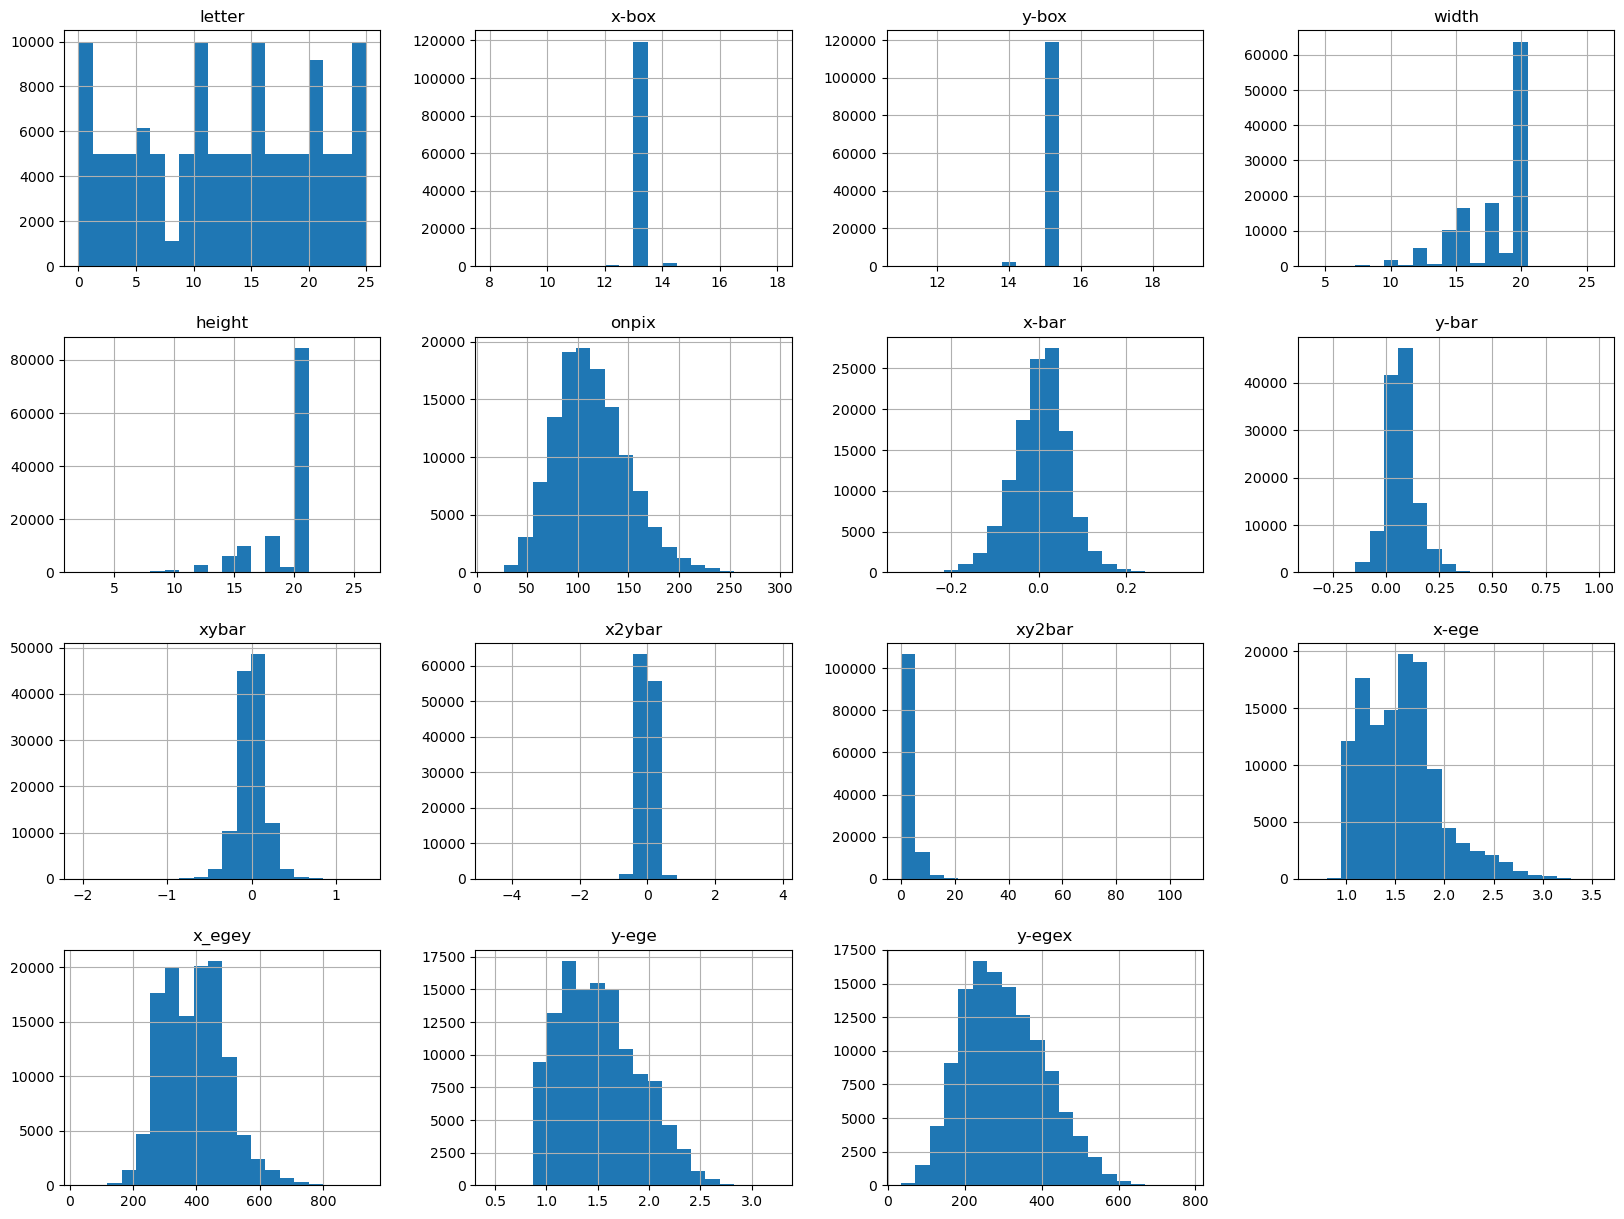

In [75]:
import matplotlib.pyplot as plt
final_df.hist(bins=20, figsize=(20,15))
plt.show()

In [76]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Select the columns you want to normalize (you can choose specific columns or normalize all)
columns_to_normalize = final_df.drop(columns = ['letter']).columns

normalized_data = scaler.fit_transform(final_df[columns_to_normalize])

# Create a new DataFrame with the normalized values
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_normalize)

# Concatenate the original DataFrame with the normalized DataFrame
normalized_df = pd.concat([final_df.drop(columns=columns_to_normalize), normalized_df], axis=1)


In [77]:
normalized_df

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,xybar,x2ybar,xy2bar,x-ege,x_egey,y-ege,y-egex
0,0,0.5,0.5,0.727273,0.750000,0.679577,0.496153,0.280255,0.629445,0.559627,0.010951,0.187500,0.357536,0.196429,0.204545
1,0,0.5,0.5,0.636364,0.750000,0.214789,0.634415,0.329582,0.553973,0.529400,0.047222,0.426136,0.528053,0.454365,0.418449
2,0,0.5,0.5,0.636364,0.750000,0.450704,0.664367,0.298545,0.619011,0.555448,0.002826,0.289773,0.435644,0.335317,0.324866
3,0,0.5,0.5,0.545455,0.750000,0.359155,0.457221,0.358917,0.586782,0.542540,0.003096,0.357955,0.469747,0.263393,0.147059
4,0,0.5,0.5,0.727273,0.750000,0.721831,0.434706,0.329394,0.603587,0.549271,0.009971,0.306818,0.451045,0.392857,0.311497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121460,25,0.6,0.5,0.681818,0.500000,0.292254,0.463718,0.328159,0.698037,0.587099,0.039026,0.168019,0.206821,0.515977,0.501337
121461,25,0.5,0.5,0.727273,0.750000,0.478873,0.554986,0.277900,0.604218,0.549523,0.007646,0.153409,0.302530,0.553571,0.596257
121462,25,0.5,0.5,0.727273,0.666667,0.454225,0.462659,0.268697,0.648042,0.567075,0.030576,0.232955,0.354235,0.500000,0.552139
121463,25,0.5,0.5,0.727273,0.750000,0.380282,0.563806,0.286517,0.582661,0.540890,0.025869,0.170455,0.333333,0.535714,0.545455


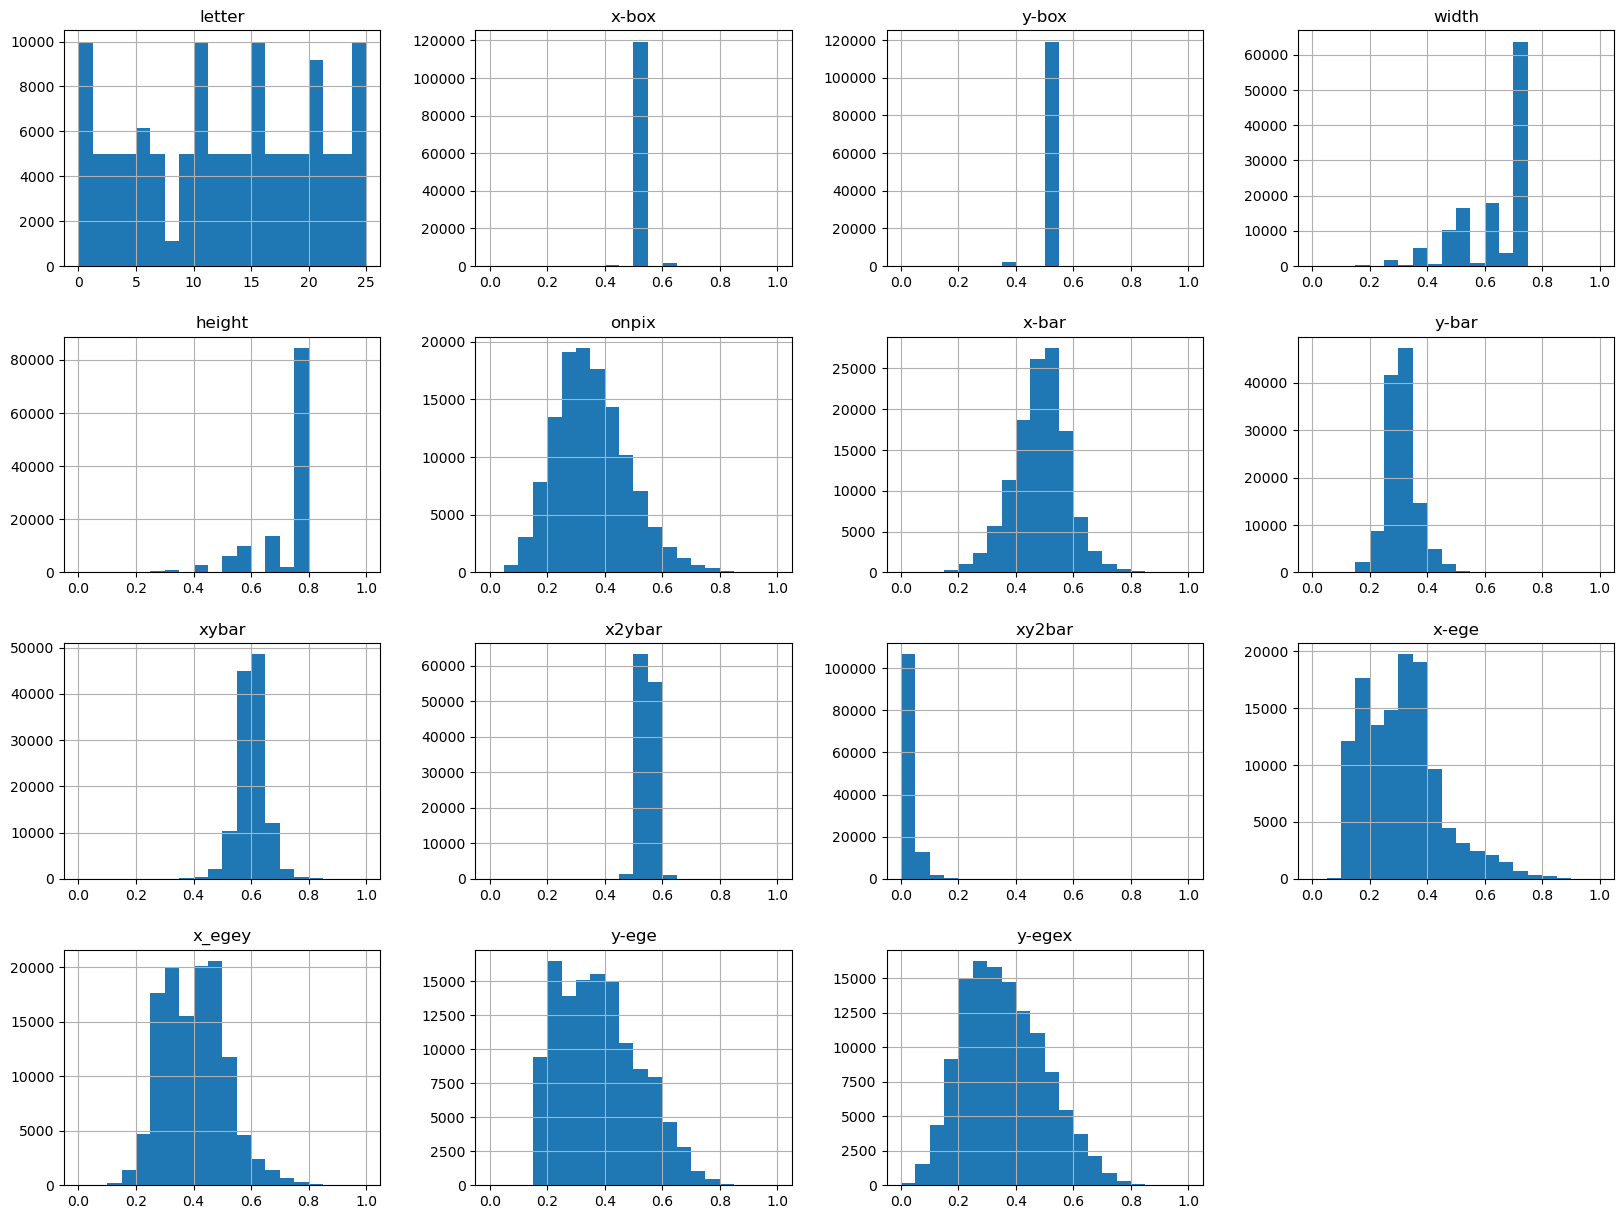

In [78]:
import matplotlib.pyplot as plt
_df.hist(bins=20, figsize=(20,15))
plt.show()

#### The next step is to split the dataset for machine learning: initially into a training set and non-training data, further dividing the latter into a validation and test set. The subsets preserve the original class distribution, vital for classification tasks. The output provides dimensions for each subset, aiding in understanding the dataset partitioning.

In [79]:
X = final_df.drop('letter', axis = 1)
y = final_df['letter']

X_train,X_nontrain,y_train,y_nontrain = train_test_split(X,y,test_size = 0.2, random_state = 42,stratify = y)
X_stack, X_test, y_stack, y_test = train_test_split(X_nontrain, y_nontrain, test_size=0.25, random_state=42, stratify=y_nontrain) #stratified sampling based on the target

print(f"X_train.shape: {X_train.shape}")
print(f"X_nontrain.shape: {X_nontrain.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"y_nontrain.shape: {y_nontrain.shape}")

print(f"X_stack.shape: {X_stack.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_stack.shape: {y_stack.shape}")
print(f"y_test.shape: {y_test.shape}")

X_train.shape: (97172, 14)
X_nontrain.shape: (24293, 14)
y_train.shape: (97172,)
y_nontrain.shape: (24293,)
X_stack.shape: (18219, 14)
X_test.shape: (6074, 14)
y_stack.shape: (18219,)
y_test.shape: (6074,)


## Supervised Machine Learning Model
### Random Forest Classifier Hyper Parameter Tuning with GridSearch:
#### The code below optimizes the RandomForestClassifier by systematically exploring various hyperparameter combinations to identify the optimal settings for this specific dataset and classification task.


In [118]:
# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Define a parameter grid to search through
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy',refit = True, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


C:\Users\ghema\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
381 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ghema\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ghema\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\ghema\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\ghema\anaconda3\Lib\site-packa

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


### Unsupservised Learning Hyper Parameter Tuning With KNN

In [61]:

# Create a KNeighborsClassifier
knn_classifier = KNeighborsClassifier()

# Define a parameter grid to search through
param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # p=1 for Manhattan distance, p=2 for Euclidean distance
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=knn_classifier, param_grid=param_grid, cv=5, scoring='accuracy',refit = True, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'n_neighbors': 7, 'p': 2, 'weights': 'distance'}


In [80]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [81]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)


# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       250
           1       0.83      0.86      0.85       250
           2       0.76      0.71      0.74       250
           3       0.63      0.63      0.63       250
           4       0.82      0.80      0.81       250
           5       0.94      0.81      0.87        59
           6       0.81      0.86      0.83       250
           7       0.80      0.84      0.82       250
           8       0.79      0.75      0.77        56
           9       0.83      0.86      0.85       250
          10       0.76      0.85      0.80       250
          11       0.96      0.98      0.97       250
          12       0.90      0.89      0.89       250
          13       0.73      0.72      0.73       250
          14       0.75      0.81      0.78       250
          15       0.87      0.88      0.87       250
          16       0.85      0.87      0.86       250
          17       0.75    

In [82]:
best_rf = RandomForestClassifier(max_depth=None, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)
best_rf.fit(X_train,y_train)
# Make predictions on the test set
y_pred = best_rf.predict(X_test)


# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       250
           1       0.85      0.88      0.86       250
           2       0.80      0.72      0.76       250
           3       0.65      0.61      0.63       250
           4       0.81      0.80      0.80       250
           5       0.92      0.80      0.85        59
           6       0.80      0.88      0.84       250
           7       0.79      0.80      0.79       250
           8       0.80      0.77      0.78        56
           9       0.82      0.85      0.83       250
          10       0.76      0.85      0.80       250
          11       0.96      0.98      0.97       250
          12       0.88      0.90      0.89       250
          13       0.74      0.74      0.74       250
          14       0.74      0.81      0.77       250
          15       0.89      0.88      0.88       250
          16       0.83      0.89      0.86       250
          17       0.74    

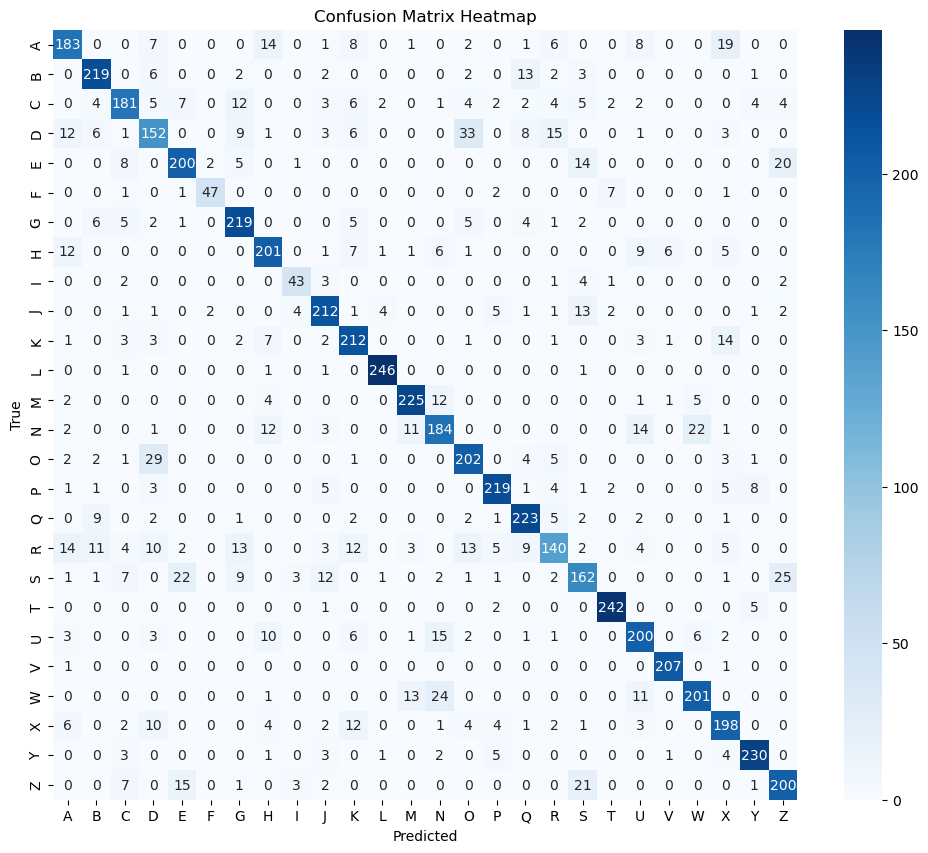

In [83]:

np.set_printoptions(threshold=np.inf)
# Get the number of classes
num_classes = len(np.unique(y_test))


num_classes = len(np.unique(y_test))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))

# Convert numerical labels to alphabetical labels
alphabet_labels = [chr(ord('A') + i) for i in range(num_classes)]

# Plot confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=alphabet_labels, yticklabels=alphabet_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [84]:
best_kn = KNeighborsClassifier(n_neighbors= 12, p= 2, weights= 'distance')
best_kn.fit(X_train,y_train)
# Make predictions on the test set
y_pred = best_kn.predict(X_test)


# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.38      0.42       250
           1       0.68      0.65      0.66       250
           2       0.47      0.42      0.44       250
           3       0.51      0.48      0.49       250
           4       0.57      0.51      0.54       250
           5       0.60      0.47      0.53        59
           6       0.61      0.78      0.69       250
           7       0.59      0.74      0.66       250
           8       0.47      0.27      0.34        56
           9       0.51      0.58      0.54       250
          10       0.55      0.65      0.60       250
          11       0.55      0.73      0.63       250
          12       0.71      0.50      0.58       250
          13       0.52      0.47      0.50       250
          14       0.59      0.58      0.59       250
          15       0.67      0.56      0.61       250
          16       0.69      0.78      0.73       250
          17       0.47    

In [85]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier

et_model = ExtraTreeClassifier()
et_model.fit(X_train,y_train)
# Make predictions on the test set
y_pred = et_model.predict(X_test)


# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.52      0.54       250
           1       0.71      0.70      0.71       250
           2       0.61      0.54      0.57       250
           3       0.51      0.53      0.52       250
           4       0.63      0.70      0.67       250
           5       0.75      0.68      0.71        59
           6       0.71      0.80      0.75       250
           7       0.66      0.74      0.70       250
           8       0.59      0.59      0.59        56
           9       0.69      0.71      0.70       250
          10       0.67      0.76      0.71       250
          11       0.91      0.86      0.88       250
          12       0.81      0.80      0.80       250
          13       0.65      0.65      0.65       250
          14       0.58      0.51      0.54       250
          15       0.71      0.71      0.71       250
          16       0.75      0.80      0.78       250
          17       0.48    

In [86]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)
# Make predictions on the test set
y_pred = dt_model.predict(X_test)


# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       250
           1       0.72      0.74      0.73       250
           2       0.63      0.56      0.59       250
           3       0.52      0.56      0.54       250
           4       0.70      0.74      0.72       250
           5       0.75      0.71      0.73        59
           6       0.76      0.81      0.79       250
           7       0.72      0.74      0.73       250
           8       0.71      0.70      0.70        56
           9       0.78      0.76      0.77       250
          10       0.66      0.75      0.70       250
          11       0.94      0.94      0.94       250
          12       0.84      0.82      0.83       250
          13       0.62      0.65      0.63       250
          14       0.65      0.57      0.61       250
          15       0.80      0.80      0.80       250
          16       0.80      0.82      0.81       250
          17       0.50    

## Semi-Supervised Machine Learning for KNN

### This code segment represents a semi-supervised learning approach, specifically using a K-Nearest Neighbors (KNN) classifier. The model_pred function assesses and displays the training and testing accuracies of a given model. Meanwhile, the semi_sup_model function implements an active learning paradigm by iteratively training the KNN model. It divides the available data into labeled and unlabeled subsets, continually augmenting the labeled set by adding confidently predicted samples from the unlabeled pool—those with a prediction probability exceeding 90%. This process continues until no further confident predictions can be made from the unlabeled data. Ultimately, this strategy leverages unlabeled data to enhance the KNN model's performance in a semi-supervised manner, gradually expanding the labeled dataset to iteratively refine the model's predictions.

In [128]:
def model_pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Predictions on training and testing data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Accuracy on training and testing data
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    print(f"Training Accuracy: {accuracy_train:.2f}")
    print(f"Testing Accuracy: {accuracy_test:.2f}")

def semi_sup_model(_model):
    X_labeled,X_unlabeled,y_labeled,y_unlabeled = train_test_split(X_train,y_train,test_size = 0.5, random_state = 42,stratify = y_train)
    while True:
        model = _model
        model.fit(X_labeled,y_labeled)
        X_unlabeled.reset_index(drop = True, inplace = True)
        y_pred_unlabel = model.predict_proba(X_unlabeled)

        # Find indices of samples with maximum probability greater than 0.90
        index = [index for index, x in enumerate(np.max(y_pred_unlabel,axis = 1)) if x> 0.90]
        if len(index)==0:
            break

        temp = X_unlabeled.iloc[index]
        X_unlabeled.drop(index,inplace = True)

        pred = pd.Series(model.predict(temp))

        X_labeled = pd.concat([X_labeled,temp],ignore_index = True)
        y_labeled = pd.concat([y_labeled,pred], ignore_index = True)
        
    
    model_pred(model,X_labeled,y_labeled,X_test,y_test)
    return model

model = semi_sup_model(KNeighborsClassifier())

Training Accuracy: 0.83
Testing Accuracy: 0.66


## Semi Supervised Learning With RandomForest 

### Creating labeled and unlabeled data:
##### The provided code segments split the available labeled data (X_train, y_train) into labeled and unlabeled subsets using a 50-50 split. The code implements a semi-supervised learning approach known as "pseudo-labeling" or "self-training" using a Random Forest classifier. Within a while loop, the algorithm iteratively predicts labels for the unlabeled data based on the current model, identifies high-confidence predictions (>90% confidence), and pseudo-labels these samples. These pseudo-labeled samples are progressively appended to the labeled dataset while being removed from the unlabeled pool. The process iterates until no further high-confidence predictions (>90% confidence) can be extracted from the remaining unlabeled data. This iterative methodology effectively expands the labeled dataset, leveraging unlabeled data to enhance the Random Forest model's performance in a semi-supervised learning setting.

### Working
#### The model_pred function calculates and showcases the accuracy of a given model on both training and testing sets. In the semi_sup_model function, the process begins by dividing the labeled (X_train, y_train) and unlabeled datasets. The algorithm initially trains a Random Forest model on the labeled data and iterates through a loop, identifying high-confidence predictions (>90%) from the unlabeled data using the trained model. These high-confidence samples are pseudo-labeled and progressively incorporated into the labeled dataset while being removed from the unlabeled pool. The model continuously re-trains using this expanded labeled dataset until no more high-confidence predictions can be extracted from the remaining unlabeled data. The final model's accuracy is then assessed using the model_pred function against the testing data (X_test, y_test). This iterative process maximizes the utilization of unlabeled data, iteratively enhancing the Random Forest model's performance in a semi-supervised learning setup.

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
import pandas as pd
import numpy as np

# Define the model prediction function
def model_pred(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    # Predictions on training and testing data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Accuracy on training and testing data
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    
    print(f"Training Accuracy: {accuracy_train:.2f}")
    print(f"Testing Accuracy: {accuracy_test:.2f}")

# Define a function for semi-supervised learning
def semi_sup_model(_model, X, y, X_test, y_test):
    # Split the data into labeled and unlabeled sets
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
    
    # Train the initial model on the labeled data
    model = _model
    model.fit(X_labeled, y_labeled)
    
    while len(X_unlabeled) > 0:
        # Make predictions on the unlabeled data
        y_pred_unlabeled = model.predict(X_unlabeled)
        
        # Confidence scores for predictions
        confidence_scores = np.max(model.predict_proba(X_unlabeled), axis=1)
        
        # Select high-confidence predictions
        high_confidence_indices = np.where(confidence_scores > 0.90)[0]
        
        if len(high_confidence_indices) == 0:
            break
        
        # Pseudo-label the high-confidence samples
        pseudo_labels = y_pred_unlabeled[high_confidence_indices]
        X_pseudo_labeled = X_unlabeled.iloc[high_confidence_indices]
        
        # Add pseudo-labeled samples to the labeled set
        X_labeled = pd.concat([X_labeled, X_pseudo_labeled], ignore_index=True)
        y_labeled = pd.concat([y_labeled, pd.Series(pseudo_labels)], ignore_index=True)
        
        # Remove pseudo-labeled samples from the unlabeled set
        X_unlabeled = X_unlabeled.drop(X_unlabeled.index[high_confidence_indices])
        
        # Retrain the model on updated labeled data
        model.fit(X_labeled, y_labeled)
    
    # Evaluate the final model
    model_pred(model, X_labeled, y_labeled, X_test, y_test)
    return model


model = semi_sup_model(RandomForestClassifier(), X_train, y_train, X_test, y_test)


Training Accuracy: 1.00
Testing Accuracy: 0.75


In [130]:
y_pred = model.predict(X_test)

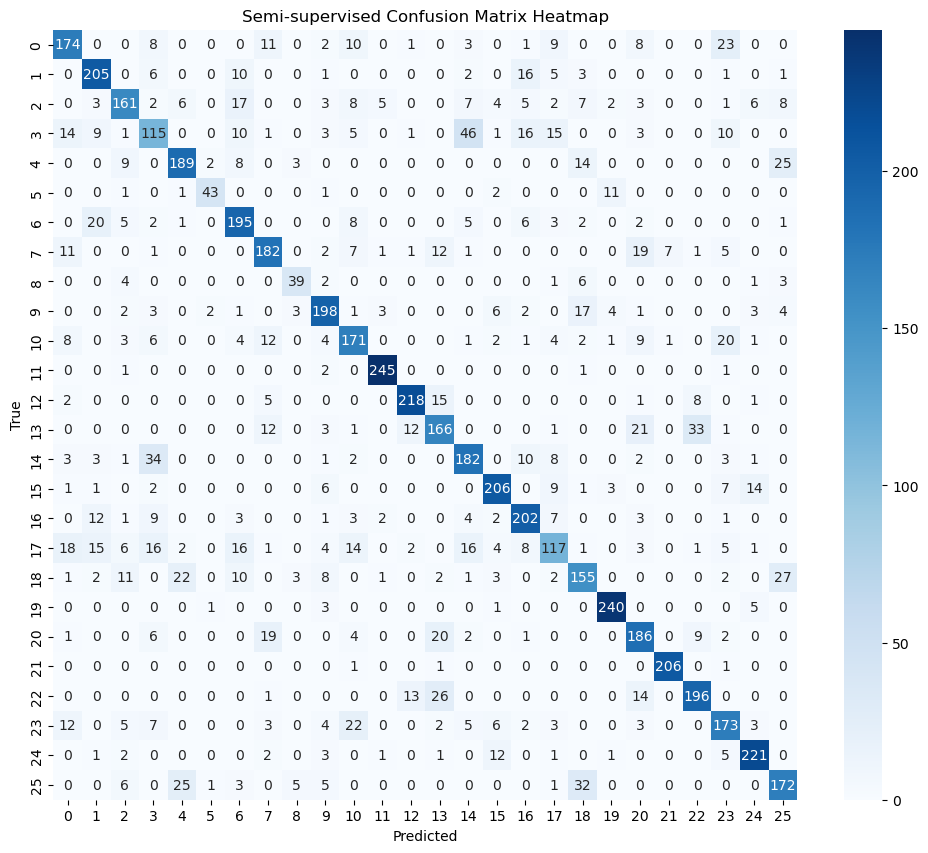

In [131]:
num_classes = len(np.unique(y_test))


# Create confusion matrix
conf_matrix_semisup = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))




plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_semisup, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Semi-supervised Confusion Matrix Heatmap')
plt.show()

In [100]:
#Functions for converting external test data

In [87]:
ext_test = pd.DataFrame({'Column_Name': X_test.columns})
imgs = []

# Specify the folder path where your images are stored
folder_path = 'test_letters'
threshold = 128

#a list of all files in the folder
files = os.listdir(folder_path)
print(files)

# Create a list to store DataFrames
dfs = []

# Define the target size
target_size = (28, 28)

# Threshold value to binarize the image
threshold = 128

# Iterate over each file
for file_name in files:
    # Create the full file path
    file_path = os.path.join(folder_path, file_name)
    
    # Check if the item is a file (not a subdirectory)
    if os.path.isfile(file_path):
        # Read the image using OpenCV
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
        # Check if the image is loaded successfully
        if image is not None:
            # Resize the image to the target size
            resized_image = cv2.resize(image, target_size)
            
            # Binarize the image
            binary_image = cv2.threshold(resized_image, threshold, 255, cv2.THRESH_BINARY_INV)[1]
            
            # Convert the binary image to a 2D NumPy array
            image_array = np.array(binary_image)
            imgs.append(image_array)
            # Extract features and add to the list of DataFrames
            dfs.append(pd.DataFrame({
                'x-box': [find_hor_pos(image_array)],
                'y-box': [find_ver_pos(image_array)],
                'width': [find_width(image_array)],
                'height': [find_height(image_array)],
                'onpix': [find_num_on_pixels(image_array)],
                'x-bar': [find_x_bar(image_array)],
                'y-bar': [find_y_bar(image_array)],
                'xybar': [find_xy_bar(image_array)],
                'x2ybar': [find_x2ybr(image_array)],
                'xy2bar': [find_xy2br(image_array)],
                'x-ege': [find_x_ege(image_array)],
                'x_egey': [find_x_egey(image_array)],
                'y-ege': [find_y_ege(image_array)],
                'y-egex': [find_y_egex(image_array)],
            }))
            
        else:
            print(f"Failed to load image: {file_path}")
# Concatenate all DataFrames into a single DataFrame
ext_test = pd.concat(dfs, ignore_index=True)


['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg']
